# План:
 
0. Задачи NLP 
0. Пример использование
0. Предобработка
1. Cуществующие подходы к анализу текстов:
    - One-hot-vector
    - Bag of words
    - Character n-grams
    - TF-IDF
2. Что такое Word2Vec?
    - описание
    - косинусная мера
    - гипепараметры модели
3. Архитектура нейронной сети
    - Continuous Bag of Words (CBOW)
    - Skip-Gram
4. Уменьшение вычислительной сложности
    - Negative Sampling
6. RNN
7. LSTM
8. Вывод

9. Полезные ссылки

<img src="7.png">

### Задачи NLP:

1. Распознавание речи
2. Анализ текста
         - Извлечение информации
         - Информационный поиск
         - Анализ тональности текста
         - Вопросно-ответные системы
3. Генерирование текста
4. Машинный перевод
5. Автоматическое реферирование, аннотирование или упрощение текста


In [10]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import os
import numpy as np
import pandas as pd
import zipfile
from smart_open import smart_open
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords

%matplotlib inline

2017-12-02 17:13:04,568 : INFO : 'pattern' package not found; tag filters are not available for English
/home/denys/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Пример использования
### Dataset
Задача sentiment analysis: отзыв и ответ [0,1]  
1-позитивный, 0-негативный

In [11]:
# data path initialization
BASE_DIR = '../'
TEXT_DATA_DIR = BASE_DIR + 'data/'
TEXT_DATA_FILE = "movie_reviews.csv"
HEADER = True

# parameters initialization
VALIDATION_SPLIT = 0.1
RANDOM_SEED = 42



df = pd.read_csv(TEXT_DATA_DIR + TEXT_DATA_FILE, nrows=50000)
data, labels = df.text, df.label
labels = np.asarray(labels, dtype='int8')



# spliting our original data on train and validation sets
data_train, data_val, labels_train, labels_val = \
    train_test_split(data, np.asarray(labels, dtype='int8'),
                     test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED, stratify=labels)

In [5]:
df.head()

,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


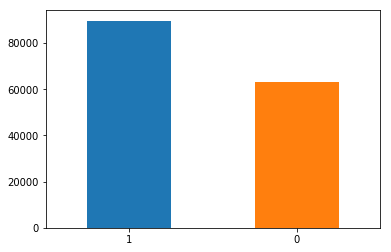

In [32]:
df.label.value_counts().plot(kind="bar", rot=0)

## Препроцессинг данных 
1)Сначала функция будет удалять все символы кроме букв верхнего и нижнего регистра;

2)Затем преобразовывает слова к нижнему регистру;

3)После чего удаляет стоп слова из текста, т.к. они не несут никакой информации о содержании;

4)Лемматизация, процесс приведения словоформы к лемме — её нормальной (словарной) форме.

In [36]:
import re
from nltk.corpus import stopwords
import pymorphy2


morph = pymorphy2.MorphAnalyzer()
stops = set(stopwords.words("english"))


def review_to_wordlist(review):
    #1)
    review_text = re.sub("[^a-zA-Z]"," ", review)
    #2)
    words = review_text.lower().split()
    #3)
    words = [w for w in words if not w in stops]
    #4)
    words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

2017-12-02 16:31:28,356 : INFO : Loading dictionaries from /home/denys/.local/lib/python3.5/site-packages/pymorphy2_dicts/data
2017-12-02 16:31:28,400 : INFO : format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names = ['0', '1']
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [9]:
def predict(vectorizer, classifier, data, labels):
    data_features = vectorizer.transform(data)
    predictions = classifier.predict(data_features)
    target = labels
    evaluate_prediction(predictions, target)

## Bag of words, n-grams, tf-idf
Пример представления предложений:  
**11 unique words**: {i, love, data, science, a, scientist, is, often, smarter, than, analyst}

Then, our corpus is mapped to feature vectors $T_1=(1,1,1,1,0,0,0,0,0,0,0)$, $T_2=(0,0,2,0,2,1,1,1,1,1,1)$

|Text #|i|love|data|science|a|scientist|is  |often|smarter|than|analyst|
|------|------|------|------|------|------|------|------|------|------|------|------|
|$T_1$|1|1|1|1|0|0|0|0|0|0|0|
|$T_2$|0|0|2|0|2|1|1|1|1|1|1|

<h2 style="font-size:20px; font-family:Verdana; color: #003300" align="left"> PROS: </h2>
* Very intuitive approach, easy to use, understand and apply - you can code it yourself
* Built-in support in many scientific/NLP libraries
* Memory-efficient sparse format, acceptable by most algorithms 
* Despite its simplicity, works well, good results could be reached
* Fast preprocessing, even on 1 core

<h2 style="font-size:20px; font-family:Verdana; color: #680000" align="left"> CONS: </h2>
* Huge corpus usually leads to huge vocabulary size (millions of words), even sparse format wouldn't help you (only hashing tricks)
* There are other approaches, manageable to catch more details (semantics, relations, structure) - word embeddings etc.
* A bag of words is an orderless representation: throwing out spatial relationships between features leads to the fact that simplified model cannot let us to distinguish between sentences, built from the same words while having opposite meanings:
<br>"New episodes **don't** feel like the first - watch it!" (positive)
<br>"New episodes feel like the first - **don't** watch it!" (negative)
<br>**However, it is somehow treated by increasing the "length" of the token (unigrams $\rightarrow$ bigrams, n-grams etc.), gluing negative particles with next word (not like $\rightarrow$ not_like), using character n-grams, skip-grams etc.** (see [this section for n-grams details](#3_5))


In [10]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=review_to_wordlist,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(data_train)

CPU times: user 14.1 s, sys: 12 ms, total: 14.1 s
Wall time: 14.1 s


In [11]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, labels_train)

CPU times: user 1 s, sys: 0 ns, total: 1 s
Wall time: 1.01 s


In [12]:
count_vectorizer.get_feature_names()[0:10]

['ability',
 'able',
 'absence',
 'absolute',
 'absolutely',
 'absorbing',
 'absurd',
 'absurdity',
 'academy',
 'accent']

accuracy 0.7578
confusion matrix
 [[1037  714]
 [ 497 2752]]
(row=expected, col=predicted)
CPU times: user 1.77 s, sys: 16 ms, total: 1.79 s
Wall time: 1.81 s


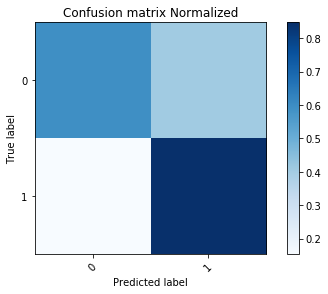

In [13]:
%%time
predict(count_vectorizer, logreg, data_val, labels_val)

### N-grams

In [22]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="word",
    ngram_range=([1,3]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(data_train)

logreg = logreg.fit(train_data_features, labels_train)

CPU times: user 12.5 s, sys: 112 ms, total: 12.6 s
Wall time: 12.6 s


In [23]:
n_gram_vectorizer.get_feature_names()[50:60]

['adults',
 'adventure',
 'adventures',
 'affair',
 'affecting',
 'after',
 'after the',
 'again',
 'against',
 'against the']

accuracy 0.7622
confusion matrix
 [[1041  710]
 [ 479 2770]]
(row=expected, col=predicted)


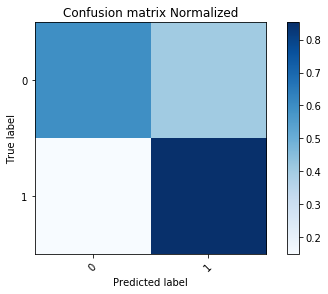

In [24]:
predict(n_gram_vectorizer, logreg, data_val, labels_val)

Точность неможко подросла, увеличивая размер ngram можно еще поднять точность. 

### TF-IDF

$$  
    \begin{cases} TF(w,T)=n_{Tw} \\ IDF(w, T)= log{\frac{N}{n_{w}}}\end{cases} \implies 
    TF\text{-}IDF(w, T) = n_{Tw}\ log{\frac{N}{n_{w}}} \ \ \ \ \forall w \in W
$$

<br> where $T$ corresponds to current document (text), 
<br>$w$ - selected word in document T, 
<br>$n_{Tw}$ - number of occurences of $w$ in text $T$, 
<br>$n_{w}$ - number of documents, containing word $w$, 
<br> $N$ - total number of documents in a corpus.


In [32]:
%%time
tf_vect = TfidfVectorizer(
    min_df=1, tokenizer=review_to_wordlist,
    preprocessor=None)

train_data_features = tf_vect.fit_transform(data_train)

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, labels_train)

CPU times: user 17.7 s, sys: 8 ms, total: 17.7 s
Wall time: 17.7 s


accuracy 0.7328
confusion matrix
 [[1066  685]
 [ 651 2598]]
(row=expected, col=predicted)


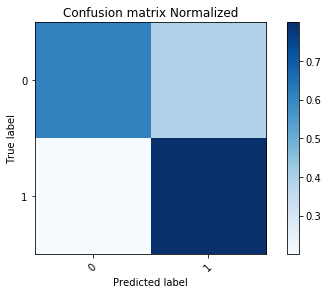

In [33]:
predict(tf_vect, logreg, data_val, labels_val)

Как вариаинт можно попробовать добавить ngrams - должно повысить точность. 

# Word2vec

Word2Vec – одна из технологий анализа семантики естественных языков, которая основана на векторном представлении слов согласно их семантической близости.

Суть алгоритма заключается в том, что он каждому слову сопоставляет числовой вектор определенной длины таким образом, чтобы близкие слова соответствуют близким векторам. Мерой близости слов выступает их контекстная близость т.е. близкие слова встречаются в тексте рядом с одинаковыми словами. 

<img src="4.png">

Расстоянием между векторами измеряется при помощи косинусного сходства (cosine similarity).Косинусная мера между векторами x и y длины n вычисляется по формуле:

$$cos(\theta)=\frac{(x,y)}{|x| |y|}=\frac{\sum\limits_{i=1}^{n}x_i y_i}{\sqrt{\sum\limits_{i=1}^{n}x_i^2} \sqrt{\sum\limits_{i=1}^{n}y_i^2}}$$

Обучаясь, Word2Vec максимизирует косинусную меру близости между векторами слов, которые встречаются в похожих контекстах и минимизирует косинусную меру между словами, которые не встречаются рядом.Word2Vec получает на вход слово, а на выход передает координаты вектора, соответствующие данному слову.

Полученные вектора можно складывать или вычитать друг из друга, сохраняя семантические связи.

В Word2Vec можно использовать две различных архитектуры нейронной сети с помощью которых осуществляется перевод слова в вектор: 

- Continuous Bag of Words (CBOW);
- Skip-gram.

Еще один важный гиперпараметр ‘size’ - размерность векторов, соответствующих словам. Если его величина мала, то модель получается грубой и плохо отображает связь между словами внутри данного массива текстов. А при большом значении роль машинного обучения теряется, и сопоставление словам векторов может превратиться в унитарное кодирование слов (one-hot encoding).

# Continuous Bag of Words (CBOW)
Когда данных мало лучше использовать CBOW, т.к. она менее склонна к переобучению. Отметич, что CBOW работает быстрее, чем skip-gram, но хуже учитывает редкие слова. В данном подходе нейронная сеть предсказывает исходное слово по его контексту ($h$ соседним словам). Нейронная сеть состоит из трех слоев: входной, скрытый, выходной.

На вход сети подаются $h$ векторов размерности $V$: $x_i=(x_i^1,x_i^2,...,x_i^V), i=1...h$, где $x_i^j=1$, если данное слово является $j$-ым словом из словаря, $x_i^k=0$ для $k\neq j$. На выходе имеем один вектор размерности $V$: $y=(y^1,y^2,...,y^V)$. На обучающейся выборке $y^j=1$, если предсказываемое слово является $j$-ым словом из словаря, $y^k=0$ для $k\neq j$. То есть нейронная сеть имеет $h\times V$ нейронов на входном слое и $V$ нейронов на выходном слое.

На скрытом слое сети $N$ нейронов. Именно с помощью весов, расставленных перед нейронами этого слоя, мы получим координаты векторных представлений слов. Функция активации на скрытом уровне — линейная, на выходном уровне — софтмакс (softmax).

Сначала рассмотрим простейший случай, когда  $h=1$.То есть будем предсказывать слово $y$ только по одному его соседу $x$. Тогда архитектура сети примет вид, изображенный на схеме:

<img src="h1.png">

Обозначим веса между входным и скрытым уровнями за $W$ - матрица размерности $V\times N$. Учитывая, что функция активации на скрытом слое линейная, вектор выходов размерности $N$ на скрытом уровне имеет вид: $$v=Wx$$

Обозначим веса между скрытым и выходным уровнями за $W'$ - матрица размерности $N\times V$. Пусть $w'_j$ - $j$-ая строка матрицы $W'$. Тогда входной сигнал $j$-ого нейрона на выходном уровне имеет вид: $$u^j=w'_j v$$

Так как на выходном уровне используется функция активации softmax, выходной сигнал на  $j$-ом нейроне выходного слоя принимает вид:

$$y^j=\frac{exp(u^j)}{\sum\limits_{k=1}^{V} exp(u^k)}$$

Такое представление имеет вероятностную интерпретацию. Пусть $w_I$ - входное слово, а $w_O$ - выходное слово. Обозначим получившееся выражение для $y^j$ за $p(w_j|w_I)$. Обучаясь, сеть максимизирует $y^{j*}=\frac{exp(u^{j*})}{\sum\limits_{k=1}^{V} exp(u^k)}=p(w_O|w_I)$, при условии что $w_O = w_{j*}$.

Сеть обучается методом обратного распространения ошибки (backpropagation), то есть сначала корректируются веса $W'$, а затем $W$. Минимизируемый функционал потерь имеет вид:
$$L=-log \ p(w_O|w_I)$$

После того, как процесс обучения завершился, $V$ строк длины $N$ матрицы $W'$ дадут нам  координаты векторов, представляющих слова из словаря.

Теперь рассмотрим общий случай для произвольного $h$. То есть будем предсказывать слово $y$ только по соседним словам $x_i, i=1...h$. Тогда архитектура сети примет вид, изображенный на схеме:


<img src="5.png">

Обозначим веса между входными и скрытым уровнями за $W$ - матрица размерности $Vh\times N$. Учитывая, что функция активации на скрытом слое линейная, вектор выходов размерности $N$ на скрытом уровне имеет вид: $$v= \frac{1}{h} W (x_1+...+x_h)$$

Далее, аналогично случаю $h=1$ получаем входной сигнал $j$ -ого нейрона на выходном слое сети $$u^j=w'_j v,$$
где $w'_j$ - $j$-ая строка матрицы весов между скрытым и выходным уровнями $W'$.

Пусть входные слова (соседние слова предсказываемого) - $w_{I,1},...,w_{I,h}$. Тогда выходной сигнал на  $j$-ом нейроне выходного слоя принимает вид:

$$y^j=\frac{exp(u^j)}{\sum\limits_{k=1}^{V} exp(u^k)}=p(w_j|w_{I,1},...,w_{I,h})$$

Как и ранее, обучаясь, сеть максимизирует $y^{j*}=\frac{exp(u^{j*})}{\sum\limits_{k=1}^{V} exp(u^k)}=p(w_O= w_{j*}|w_{I,1},...,w_{I,h})$, при условии что $w_O = w_{j*}$.

Минимизируемый функционал потерь имеет вид:
$$L=-log \ p(w_O|w_{I,1},...,w_{I,h})$$

# Skip-Gram
В случае когда данных много, то лучше использовать Skip-Gram. Данный подход обратен CBOW: по заданному слову предсказывается его контекст ($h$ соседних слов). Сеть также состоит из трех слоев: входной, скрытый, выходной.

На скрытом слое сети, как и ранее, $N$ нейронов, а функции активации на скрытом уровне — линейная, на выходном уровне — софтмакс (softmax).

Схема архитектуры сети изображена на схеме:


<img src="6.png">

# Уменьшение вычислительной сложности
### Negative Sampling
Идея этого метода состоит в том, чтобы пересчитывать функционал потерь не по всем словам из словаря, а только по меньшему количеству слов. Тем самым пересчитываться будут вектора не всех слов из словаря, а только некоторого подмножества.

In [1]:
from gensim.models import KeyedVectors

натренированая модель на Google News corpus

In [ ]:
%%time 
wv = KeyedVectors.load_word2vec_format(
    "/home/denys/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

In [6]:
model.most_similar("women", topn=3)

[('females', 0.656234860420227), ('lesbians', 0.5949513912200928), ('woman', 0.5667258501052856)]


### Проекция на дву мерную плоскость

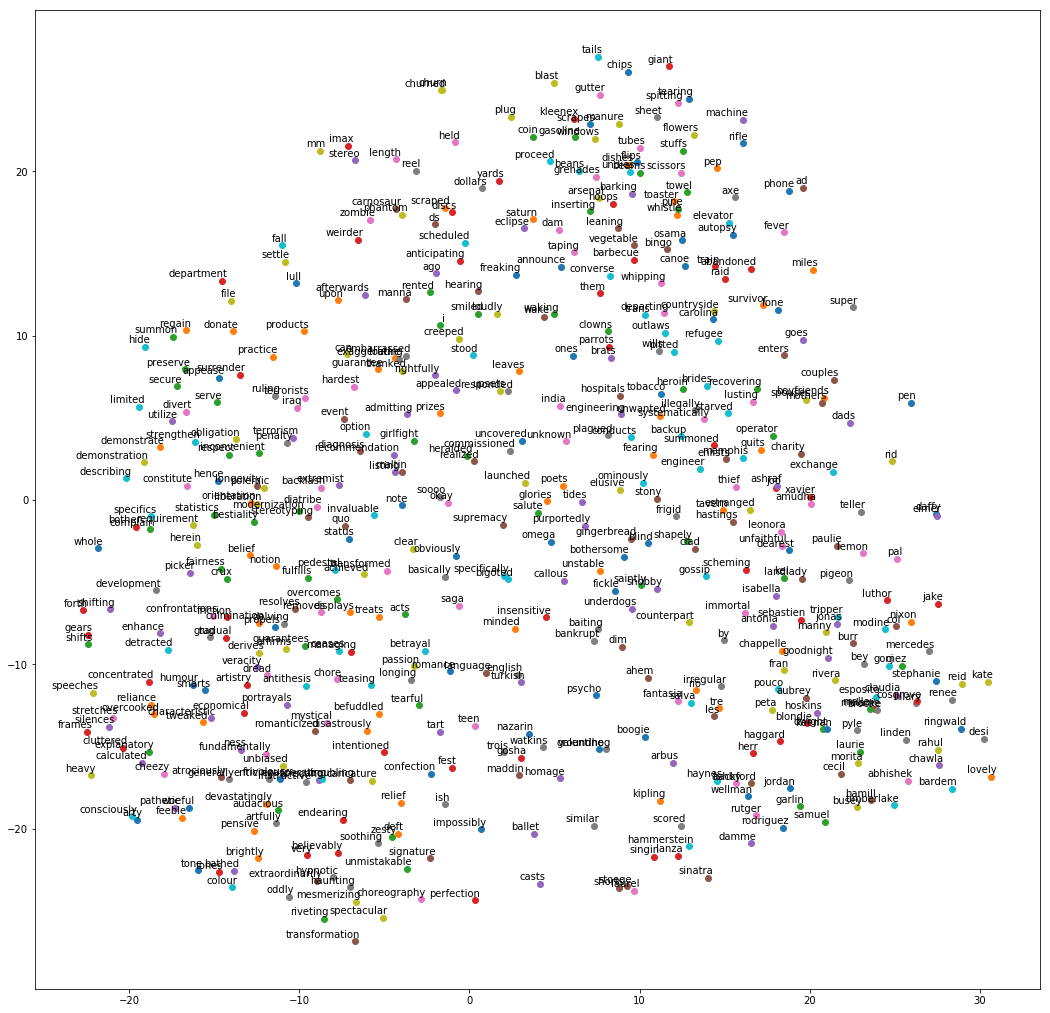

### Аналоги

Стоит отметить, что Word2Vec не единственная технология. Например:

1)[Glove](https://nlp.stanford.edu/projects/glove/), тут их репозиторий с объяснением работы,инструкцией и предобученными моедлями на вики и твиттере;

2)[AdaGram](https://github.com/lopuhin/python-adagram) репозиторий.

### Neural Networks for NLP

Теперь используя Word2vec embedding преобразуем предложения в векторное представления. 

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# initialize dictionary size and maximum sentence length
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 40

print("Original sentence:\n", data_train[0])

# create a dictionary with Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data_train)

# replacing words with their indexes from our dictionary
X_train = tokenizer.texts_to_sequences(data_train)
X_val = tokenizer.texts_to_sequences(data_val)

print("Sentence in indexes:\n", X_train[0])

# fit each sentence to max length
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

print("Sentence fitted to max length:\n", X_train[0])

Original sentence:
 To an entire generation of filmgoers, it just might represent the most significant leap in storytelling that they will ever see...
Sentence in indexes:
 [23, 2, 96, 1195, 21, 1, 36, 2557, 479, 12, 2, 171, 32, 121, 35, 81, 326, 11, 8]
Sentence fitted to max length:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   23    2   96 1195   21    1   36 2557  479
   12    2  171   32  121   35   81  326   11    8]


In [20]:
# path to embeddings file
EMBEDDINGS_DIR = BASE_DIR + 'embeddings'
EMBEDDINGS_FILE = 'glove.6B.50d.txt'

EMBEDDING_DIM = 50

# choose only 10000 words from our dictionary
first_10000 = {k: v for k, v in tokenizer.word_index.items() if v < 10000}

# upload embeddings
embeddings = {}
with zipfile.ZipFile(os.path.join(EMBEDDINGS_DIR, EMBEDDINGS_FILE+'.zip')) as myzip:
    with myzip.open(EMBEDDINGS_FILE) as f:
        for line in f:
            values = line.split()
            word = values[0].decode('UTF-8')
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
        del values, word, coefs, line
print("Number of words with vector representation:", len(embeddings))

Number of words with vector representation: 400000


In [21]:
# prepare embeddings matrix where each row is word index

embedding_matrix = np.zeros((tokenizer.num_words, EMBEDDING_DIM))
for word, i in first_10000.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

В таком виде теперь представляется каждое слово в словаре

In [23]:
embedding_matrix[1]

array([  4.18000013e-01,   2.49679998e-01,  -4.12420005e-01,
         1.21699996e-01,   3.45270008e-01,  -4.44569997e-02,
        -4.96879995e-01,  -1.78619996e-01,  -6.60229998e-04,
        -6.56599998e-01,   2.78430015e-01,  -1.47670001e-01,
        -5.56770027e-01,   1.46579996e-01,  -9.50950012e-03,
         1.16579998e-02,   1.02040000e-01,  -1.27920002e-01,
        -8.44299972e-01,  -1.21809997e-01,  -1.68009996e-02,
        -3.32789987e-01,  -1.55200005e-01,  -2.31309995e-01,
        -1.91809997e-01,  -1.88230002e+00,  -7.67459989e-01,
         9.90509987e-02,  -4.21249986e-01,  -1.95260003e-01,
         4.00710011e+00,  -1.85939997e-01,  -5.22870004e-01,
        -3.16810012e-01,   5.92130003e-04,   7.44489999e-03,
         1.77780002e-01,  -1.58969998e-01,   1.20409997e-02,
        -5.42230010e-02,  -2.98709989e-01,  -1.57490000e-01,
        -3.47579986e-01,  -4.56370004e-02,  -4.42510009e-01,
         1.87849998e-01,   2.78489990e-03,  -1.84110001e-01,
        -1.15139998e-01,

## Recurrent neural networks (RNN)

![1.png](./1.png)


Рекуррентые нейронные сети. Это сети, содержащие обратные связи и позволяющие сохранять информацию.

![2.png](./2.png)

Иногда для выполнения текущей задачи нам необходима только недавняя информация. Рассмотрим, например, языковую модель, пытающуюся предсказать следующее слово на основании предыдущих. Если мы хотим предсказать последнее слово в предложении “облака плывут по небу”, нам не нужен более широкий контекст; в этом случае довольно очевидно, что последним словом будет “небу”. В этом случае, когда дистанция между актуальной информацией и местом, где она понадобилась, невелика, RNN могут обучиться использованию информации из прошлого. 

Но бывают случаи, когда нам необходимо больше контекста. Допустим, мы хотим предсказать последнее слово в тексте “Я вырос во Франции… Я бегло говорю по-французски”. Ближайший контекст предполагает, что последним словом будет называние языка, но чтобы установить, какого именно языка, нам нужен контекст Франции из более отдаленного прошлого. Таким образом, разрыв между актуальной информацией и точкой ее применения может стать очень большим.

К сожалению, по мере роста этого расстояния, RNN теряют способность связывать информацию.
Так называемая __vanishing gradients problem__ 


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Embedding
from keras.layers import SimpleRNN
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

NAME = "simple_rnn"

# embedding layer initialization

embedding_layer = Embedding(tokenizer.num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
                            
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(100))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# callbacks initialization
# stop training model if accuracy does not increase more than five epochs
callback_1 = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto')
# best model saving
callback_2 = ModelCheckpoint("../models/model_{}.hdf5".format(NAME), monitor='val_acc',
                                 save_best_only=True, verbose=1)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
#model.fit(X_train, labels_train, validation_data=[X_val, labels_val], 
#          batch_size=1024, epochs=100, callbacks=[callback_1, callback_2, callback_3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 515,201
Trainable params: 15,201
Non-trainable params: 500,000
_________________________________________________________________


## Long short-term memory (LSTM)

LSTM – необычная модификация рекуррентной нейронной сети, которая на многих задачах значительно превосходит стандартную версию. Почти все впечатляющие результаты RNN достигнуты именно с помощью LSTM. 

![3.png](./3.png)

Проилюстрируем разницу между RNN и  LSTM на следующем примере.

<img src="http://i.imgur.com/PnWiSCf.png" alt="pokemon_rnn" style="heigh: 100px;"/>

As can be seen from the picture, the recurrent network remembers what happened a couple of seconds ago and can roughly understand what caused the appearance of water in the next episode.

What "thinks" LSTM:
<img src="http://i.imgur.com/EGZIUuc.png" alt="pokemon_lstm" style="heigh: 100px;"/>

LSTM recalls what happened in the previous episode, also recall long-term memory and focuses only on the right information for a specific episode.

Sources:
1. [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. [Русская версия на github](https://habrahabr.ru/company/wunderfund/blog/331310/)

In [41]:
from keras.layers import LSTM

# инициализируем слой эмбеддингов
NAME = "simple_lstm"

embedding_layer = Embedding(tokenizer.num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
                            
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
#model.fit(X_train, labels_train, validation_data=[X_val, labels_val], 
#          batch_size=1024, epochs=100, callbacks=[callback_1, callback_2, callback_3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 50)            500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 560,501
Trainable params: 60,501
Non-trainable params: 500,000
_________________________________________________________________


Stacked LSTM performes a little bit worse than bidirectional LSTM: train – **79.09%**, validation – **79.80%**.

As you can see, models performance is very close, so it worth to try different architectures and regularization techniques to get the best accuracy on a specific task.

These approaches are basic in applying recurrent neural networks for the sentiment analysis problem. Improve accuracy can be the following modifications:

- size of embeddings;
- the number of words in the dictionary;
- the maximum long sentence;
- modification of the network architecture;
- ensembles.

# Использованные материалы: 
- http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/  
- Лекции с  UCU summer school  
- Статьи Open Data Science Community  
- https://habrahabr.ru/company/wunderfund/blog/331310/  

# Полезные ссылки
- [туториал Bag of Words Meets Bags of Popcorn на kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial)
- [библиотека gensim](https://radimrehurek.com/gensim/index.html)
- [Word2Vec Parameter Learning Explained, Xin Rong](https://arxiv.org/pdf/1411.2738.pdf)
- [Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Negative-Sampling Word-Embedding Method](https://arxiv.org/pdf/1402.3722.pdf)
